# Exposure time factor with SV1 data
Lets re-fit the polynomial regression exposure time factor model using BOSS sky flux data, DESI CMX sky flux data, and **DESI SV1 sky flux data**. Recall, exposure time factor from sky brightness is calculated as

$t_{\rm BGS} = t_{\rm nom} \frac{(\rm sky~flux) t_{\rm nom} + \sqrt{t_{\rm nom}^2 (\rm sky~flux)_{\rm BGS}^2 + 4{\rm RN}^2 ((\rm sky~flux)_{\rm nom}t_{\rm nom} + {\rm RN}^2)}}{2((\rm sky~flux)_{\rm nom} t_{\rm nom} + {\rm RN}^2)}$ at $5000\AA$

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import h5py
import fitsio
import numpy as np 
from astropy import units as u
from scipy.signal import medfilt
from scipy.interpolate import interp1d
# --- desihub ---
import desisim.simexp
import specsim.instrument
from desimodel.io import load_throughput

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
if 'NERSC_HOST' not in os.environ:
    dir_cmx = '/Users/ChangHoon/data/feasiBGS/cmx/'
    dir_sky = '/Users/ChangHoon/data/feasiBGS/sky/'
else: 
    dir_cmx = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'
    dir_sky = '/global/cfs/cdirs/desi/users/chahah/sky/'

In [4]:
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.8) * u.Angstrom

# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave.to('Angstrom').value, dwave_out=0.8, specsim_config_file='desi')

instrument = specsim.instrument.initialize(config, True)

plate_scale = config.load_table(config.instrument.plate_scale, ['radius', 'radial_scale', 'azimuthal_scale'], interpolate=False)
radial_fiber_size = (0.5 * instrument.fiber_diameter / instrument.radial_scale(plate_scale['radius']))
azimuthal_fiber_size = (0.5 * instrument.fiber_diameter / instrument.azimuthal_scale(plate_scale['radius']))

desi_fiber_area = np.mean(np.pi*radial_fiber_size * azimuthal_fiber_size)
print('mean desi fiber area %f' % desi_fiber_area.value)

boss_fiber_area = np.pi

nom_waves = [] 
for camera in instrument.cameras: 
    nom_waves.append(camera.output_wavelength.value)

mean desi fiber area 1.862089


In [5]:
def read_cmx_skies(): 
    ''' read CMX sky fibers and return median sky surface brightness measurements for each exposure
    '''
    #fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.coadd_gfa.minisv2_sv0.hdf5'), 'r')
    fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.cmx.v1.hdf5'), 'r')
    
    sky_data = {}
    for k in fsky.keys():
        sky_data[k] = fsky[k][...]
    
    bad_seeing = (sky_data['tileid'] == 70502) | (sky_data['date'] == 20200314) #bad seeing on Feb 25 and 27

    exp_cuts = ~bad_seeing

    for k in sky_data.keys(): 
        if 'wave' not in k: 
            sky_data[k] = sky_data[k][exp_cuts]
        else:
            sky_data[k] = sky_data[k]
            
    uniq_exps, i_uniq = np.unique(sky_data['expid'], return_index=True)

    # compile median observing conditions for each unique exposure and
    # get the median sky fluxes of all sky fibers
    sky_uniq_exps = {} 
    for k in ['date', 'tileid', 'expid', 
              'airmass', 'moon_ill', 'moon_alt', 'moon_sep', 
              'sun_alt', 'sun_sep', 'exptime', 'transparency']: 
        sky_uniq_exps[k] = np.zeros(len(uniq_exps))

    sky_uniq_exps['wave_b'] = sky_data['wave_b']
    sky_uniq_exps['wave_r'] = sky_data['wave_r']
    sky_uniq_exps['wave_z'] = sky_data['wave_z']
    
    sky_uniq_exps['sky_b'] = np.zeros((len(uniq_exps), len(sky_data['wave_b'])))
    sky_uniq_exps['sky_r'] = np.zeros((len(uniq_exps), len(sky_data['wave_r'])))
    sky_uniq_exps['sky_z'] = np.zeros((len(uniq_exps), len(sky_data['wave_z'])))
    
    print('date \t\t tile \t exp \t texp \t airmass \t moon_ill \t moon_alt \t moon_sep')
    for _i, _i_uniq, _exp in zip(range(len(i_uniq)), i_uniq, uniq_exps): 
        _is_exp = (sky_data['expid'] == _exp)

        sky_uniq_exps['date'][_i] = sky_data['date'][_i_uniq]
        sky_uniq_exps['tileid'][_i] = sky_data['tileid'][_i_uniq]
        sky_uniq_exps['expid'][_i] = sky_data['expid'][_i_uniq]
        sky_uniq_exps['airmass'][_i] = np.median(sky_data['airmass'][_is_exp])
        sky_uniq_exps['moon_ill'][_i] = np.median(sky_data['moon_ill'][_is_exp])
        sky_uniq_exps['moon_alt'][_i] = np.median(sky_data['moon_alt'][_is_exp])
        sky_uniq_exps['moon_sep'][_i] = np.median(sky_data['moon_sep'][_is_exp])
        sky_uniq_exps['transparency'][_i] = np.median(sky_data['transparency'][_is_exp])

        sky_uniq_exps['exptime'][_i] = sky_data['exptime'][_is_exp][0]

        sky_uniq_exps['sun_alt'][_i] = np.median(sky_data['sun_alt'][_is_exp])
        sky_uniq_exps['sun_sep'][_i] = np.median(sky_data['sun_sep'][_is_exp])        
        #sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_b'][_is_exp], axis=0) 
        #sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_r'][_is_exp], axis=0) 
        #sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_z'][_is_exp], axis=0)

        sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_sb_b'][_is_exp], axis=0) 
        sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_sb_r'][_is_exp], axis=0) 
        sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_sb_z'][_is_exp], axis=0)

        print('%i \t %i \t %i \t %.f \t %.2f \t\t %.2f \t\t %.1f \t\t %f' % 
              (sky_data['date'][_i_uniq], sky_data['tileid'][_i_uniq], sky_data['expid'][_i_uniq], 
               sky_uniq_exps['exptime'][_i], 
               sky_uniq_exps['airmass'][_i], sky_uniq_exps['moon_ill'][_i], 
               sky_uniq_exps['moon_alt'][_i], sky_uniq_exps['moon_sep'][_i]))

    return sky_uniq_exps

In [6]:
def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']

    sky_boss['sun_alt'] = boss['SUN_ALT']
    sky_boss['sun_sep'] = boss['SUN_SEP']
        
    sky_boss['wave_b'] = boss['WAVE'] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    return sky_boss

In [7]:
_cmx_skies = read_cmx_skies()

transp_cut = (_cmx_skies['transparency'] > 0.9)
cmx_skies = {} 
for k in _cmx_skies.keys():
    if k not in ['wave_b', 'wave_r', 'wave_z']: 
        cmx_skies[k] = _cmx_skies[k][transp_cut]
    else: 
        cmx_skies[k] = _cmx_skies[k]

date 		 tile 	 exp 	 texp 	 airmass 	 moon_ill 	 moon_alt 	 moon_sep
20200303 	 70500 	 52932 	 500 	 1.15 		 0.65 		 35.8 		 34.692321
20200303 	 70500 	 52934 	 500 	 1.19 		 0.65 		 31.0 		 34.557860
20200303 	 70500 	 52936 	 500 	 1.25 		 0.65 		 26.2 		 34.423687
20200303 	 70500 	 52938 	 500 	 1.31 		 0.65 		 21.6 		 34.292890
20200303 	 70500 	 52940 	 500 	 1.39 		 0.65 		 17.0 		 34.162246
20200303 	 70500 	 52942 	 500 	 1.49 		 0.66 		 12.2 		 34.026271
20200304 	 70510 	 53078 	 500 	 1.43 		 0.74 		 55.8 		 79.209427
20200304 	 70510 	 53080 	 500 	 1.34 		 0.75 		 52.1 		 79.061903
20200304 	 70510 	 53081 	 500 	 1.29 		 0.75 		 49.2 		 78.944160
20200304 	 70510 	 53082 	 500 	 1.24 		 0.75 		 46.4 		 78.827312
20200304 	 70510 	 53083 	 500 	 1.19 		 0.75 		 43.5 		 78.710167
20200304 	 70510 	 53084 	 500 	 1.16 		 0.75 		 40.7 		 78.593746
20200304 	 70510 	 53085 	 500 	 1.13 		 0.75 		 37.8 		 78.477009
20200304 	 70510 	 53086 	 500 	 1.10 		 0.75 		 34.9 		 78.

In [8]:
boss_skies = read_BOSS_skies()

remove boss skies during twilight defined as: sun_alt > -15

In [9]:
twilight = boss_skies['sun_alt'] > -15.
print('%i of %i are twilight' % (np.sum(twilight), len(boss_skies['sun_alt'])))

40 of 1144 are twilight


In [10]:
for k in boss_skies.keys():
    boss_skies[k] = boss_skies[k][~twilight]

# SV1 sky data
Read in observing conditions and sky brightnesses for SV1 exposures

In [11]:
import astropy.table as atable

sv1_obs_cond = atable.Table.read('/global/homes/c/chahah/projects/bgs-cmxsv/doc/nb/sv1.bright_exps.20210202.obs_cond.hdf5', format='hdf5')
sv1_Iskies = np.load('/global/homes/c/chahah/projects/bgs-cmxsv/doc/nb/sv1.bright_exps.20210202.Isky.npy')
sv1_wave = np.load('/global/homes/c/chahah/projects/bgs-cmxsv/doc/nb/sv1.bright_exps.20210202.wave.npy')

# some have nan obs conditions 
cut = (np.isfinite(sv1_obs_cond['MOON_ZD_DEG']) & np.isfinite(sv1_obs_cond['MOON_SEP_DEG']))
sv1_obs_cond = sv1_obs_cond[cut]
sv1_Iskies = sv1_Iskies[cut,:]

In [12]:
sv1_obs_cond[:5]

NIGHT,EXPID,AIRMASS,SKY_MAG_AB,MOON_ILLUMINATION,MOON_SEP_DEG,MOON_ZD_DEG,TRANSPARENCY
float64,int64,float64,float64,float64,float64,float64,float64
20201214.0,67680,1.01446950715555,20.033265558674195,0.002528564919546986,117.60668865736183,109.91266545656522,0.9536320212970133
20201214.0,67689,1.0054813028748142,19.987979223113744,0.003080145432996482,117.03469820593651,122.47619267144707,0.9588061164038733
20201214.0,67690,1.0081020544176496,19.90494279987209,0.003145048679245861,116.97116361330552,123.90108438754235,0.9626791455075867
20201214.0,67733,1.3984100339458183,19.55505403689506,0.004661884690157691,119.38604955752567,154.09523148602173,0.9482525059763185
20201214.0,67784,1.1557381840485181,19.9633982737043,0.009050079352064345,122.21660637888891,135.2912333407487,0.9793342756178205


[]

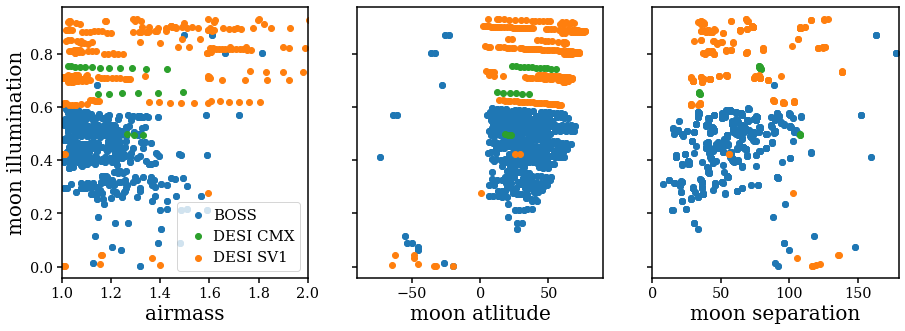

In [13]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], c='C2', label='DESI CMX')
sub.scatter(sv1_obs_cond['AIRMASS'], sv1_obs_cond['MOON_ILLUMINATION'], c='C1', label='DESI SV1')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C0')
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], c='C2')
sub.scatter(90. - sv1_obs_cond['MOON_ZD_DEG'], sv1_obs_cond['MOON_ILLUMINATION'], c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], c='C2', label='DESI CMX')
sub.scatter(sv1_obs_cond['MOON_SEP_DEG'], sv1_obs_cond['MOON_ILLUMINATION'], c='C1')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

# calculat expected exposure factor

In [14]:
# nominal dark sky
atm_config  = config.atmosphere
sb_dict     = config.load_table(atm_config.sky, 'surface_brightness', as_dict=True)
Isky_dark   = sb_dict['dark']

# also calculate nominal sky electrons for 150s exposure and read noise electrons
nom_sky_fibflux = Isky_dark * desi_fiber_area 

Isky_cont_dark = medfilt(Isky_dark, 1001)

def get_exposure_factor(_wave_sb, _sky_sb, tnom=150, wavelength=5000):
    if wavelength < nom_waves[0].max(): 
        i_cam = 0 
    elif nom_waves[0].max() < wavelength & wavelength < nom_waves[1].max(): 
        i_cam = 1
    elif nom_waves[1].max() < wavelength:
        i_cam = 2
    else: 
        raise ValueError
        
    # first calculate nominal sky electrons and the read noise term (read noise electrons^2)
    nom_sky_photon = nom_sky_fibflux.to(u.erg/u.Angstrom/u.s/u.cm**2) * instrument.photons_per_bin * tnom * u.s
    camera = instrument.cameras[i_cam]

    nom_sky_electron = camera.downsample(camera.apply_resolution(nom_sky_photon * camera.throughput))    
    read_noise_electron = camera.downsample(camera.read_noise_per_bin.to(u.electron).value)
    rn_term = read_noise_electron**2
        
    # stitch together the spectrographs
    sbs_interp = [] 
    for _w, _sb in zip(_wave_sb, _sky_sb): 
        fintrp = interp1d(_w, _sb, fill_value=0., bounds_error=False) 
        sbs_interp.append(fintrp(wave))
    
    _sbs = np.amax(sbs_interp, axis=0)         

    sky_sb = _sbs * Isky_dark.unit
    sky_fibflux = sky_sb * desi_fiber_area 
    sky_photon = sky_fibflux.to(u.erg/u.Angstrom/u.s/u.cm**2) * instrument.photons_per_bin * tnom * u.s

    camera = instrument.cameras[i_cam]
    sky_electron = camera.downsample(camera.apply_resolution(sky_photon * camera.throughput))

    sky_bgs = np.interp(wavelength, camera.output_wavelength.value, sky_electron)
    rn = np.interp(wavelength, nom_waves[i_cam], rn_term)
    sky_nom = np.interp(wavelength, nom_waves[i_cam], nom_sky_electron)

    fsky = (sky_bgs + np.sqrt(sky_bgs**2 + 4 * rn * (sky_nom + rn)))/(2. * (sky_nom + rn))
    return fsky

# exposure_factor(obs condition)

In [15]:
desi_tnom200_5000 = np.zeros(len(cmx_skies['airmass']))

_waves = [cmx_skies['wave_b'], cmx_skies['wave_r'], cmx_skies['wave_z']]
for i in range(len(cmx_skies['airmass'])): 
    _sky_sbs_i = [cmx_skies['sky_b'][i], cmx_skies['sky_r'][i], cmx_skies['sky_z'][i]]

    desi_tnom200_5000[i] = get_exposure_factor(_waves, _sky_sbs_i, tnom=200, wavelength=5000)

In [16]:
boss_tnom200_5000 = np.zeros(len(boss_skies['airmass']))

_waves = [boss_skies['wave_b'][i], boss_skies['wave_r'][i]]
for i in range(len(boss_skies['airmass'])): 
    _sky_sbs_i = [boss_skies['sky_b'][i], boss_skies['sky_r'][i]]

    boss_tnom200_5000[i] = get_exposure_factor(_waves, _sky_sbs_i, tnom=200, wavelength=5000)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [17]:
sv1_tnom200_5000 = np.zeros(sv1_Iskies.shape[0])
for i in range(sv1_Iskies.shape[0]): 
    sv1_tnom200_5000[i] = get_exposure_factor([sv1_wave], [sv1_Iskies[i]], tnom=200, wavelength=5000)

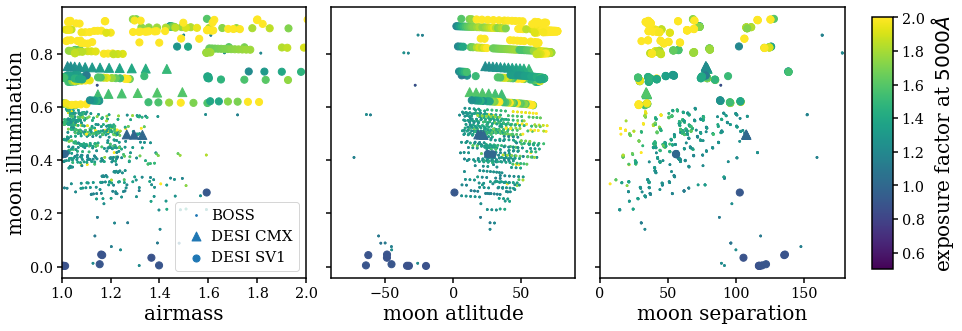

In [18]:
boss_5000 = boss_tnom200_5000
desi_5000 = desi_tnom200_5000
sv1_5000 = sv1_tnom200_5000

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_5000, s=3, vmin=0.5, vmax=2., label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], marker='^', c=desi_5000, s=80, vmin=0.5, vmax=2., label='DESI CMX')
sub.scatter(sv1_obs_cond['AIRMASS'], sv1_obs_cond['MOON_ILLUMINATION'], c=sv1_5000, s=50, vmin=0.5, vmax=2., label='DESI SV1')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_5000, s=3, vmin=0.5, vmax=2)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], marker='^', c=desi_5000, s=80, vmin=0.5, vmax=2.)
sub.scatter(90. - sv1_obs_cond['MOON_ZD_DEG'], sv1_obs_cond['MOON_ILLUMINATION'], c=sv1_5000, s=50, vmin=0.5, vmax=2., label='DESI SV1')

sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_5000, s=3, vmin=0.5, vmax=2.)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], marker='^', c=desi_5000, s=80, vmin=0.5, vmax=2.)
sub.scatter(sv1_obs_cond['MOON_SEP_DEG'], sv1_obs_cond['MOON_ILLUMINATION'], c=sv1_5000, s=50, vmin=0.5, vmax=2., label='DESI SV1')

sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='exposure factor at $5000\AA$', fontsize=20)

# re-fit exposure factor model now with SV1 data

In [19]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from itertools import chain, combinations_with_replacement

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


--- tnom = 150 --
[ 0.00000000e+00 -7.65192309e-02  4.50339775e-01 -1.97942832e-02
 -3.41415322e-02 -6.12718783e-01  2.92105504e-01  6.35543300e-03
  4.33218913e-02  4.52094789e-02 -9.84060307e-03 -7.08736998e-03
  1.87100312e-04  1.29286060e-04  2.29783430e-04  4.82259115e-01
  1.98321998e-01 -1.93484942e-02 -2.97180320e-02  6.69777743e-02
 -4.61085961e-03  3.41750827e-02  3.30879455e-04  3.81656037e-04
  9.06394046e-05  1.49819306e-02 -1.36399405e-03  1.96793987e-02
  8.62206556e-05 -4.98643387e-04 -3.98201905e-04 -2.55149678e-06
 -2.84521671e-06 -2.17588659e-06 -1.22082693e-06]
1.8711798724721023


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


--- tnom = 170 --
[ 0.00000000e+00 -8.47161918e-02  5.09140318e-01 -2.21689858e-02
 -3.82829563e-02 -6.82547805e-01  3.30443697e-01  6.96121973e-03
  4.85970310e-02  5.16826651e-02 -1.11869516e-02 -7.84891835e-03
  2.11236410e-04  1.44634107e-04  2.56482375e-04  5.39172275e-01
  2.17955039e-01 -2.16472707e-02 -3.33864806e-02  7.37805327e-02
 -5.05383302e-03  3.82830633e-02  3.70874089e-04  4.29673186e-04
  1.02787431e-04  1.72136448e-02 -1.50046818e-03  2.18334958e-02
  9.65000425e-05 -5.57451902e-04 -4.44714387e-04 -2.86562898e-06
 -3.20549339e-06 -2.45240669e-06 -1.37286608e-06]
1.9732660265121995


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


--- tnom = 200 --
[ 0.00000000e+00 -9.58679635e-02  5.93841512e-01 -2.55861615e-02
 -4.41591474e-02 -7.79678593e-01  3.85818939e-01  7.79679323e-03
  5.59921835e-02  6.11104223e-02 -1.31110611e-02 -8.79745360e-03
  2.46048016e-04  1.67042274e-04  2.94236583e-04  6.18672422e-01
  2.44202035e-01 -2.48791060e-02 -3.85417472e-02  8.30483197e-02
 -5.63610422e-03  4.40148404e-02  4.27190211e-04  4.97703948e-04
  1.20209680e-04  1.93038858e-02 -1.68032918e-03  2.47257673e-02
  1.10776356e-04 -6.39467548e-04 -5.09258980e-04 -3.31065269e-06
 -3.72136838e-06 -2.85115773e-06 -1.59214888e-06]
2.1185346942680368


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


--- tnom = 220 --
[ 0.00000000e+00 -1.02634030e-01  6.47694841e-01 -2.77657185e-02
 -4.78539584e-02 -8.39732104e-01  4.21104384e-01  8.31458698e-03
  6.05850892e-02  6.71532006e-02 -1.43223633e-02 -9.31516873e-03
  2.68225131e-04  1.81542250e-04  3.17943153e-04  6.67947574e-01
  2.59892026e-01 -2.68947718e-02 -4.17491712e-02  8.87103338e-02
 -5.97815265e-03  4.75607734e-02  4.62337315e-04  5.40334638e-04
  1.31226062e-04  1.99295303e-02 -1.78664043e-03  2.64513742e-02
  1.19566281e-04 -6.90228023e-04 -5.49024884e-04 -3.58983421e-06
 -4.04795876e-06 -3.10523364e-06 -1.73200204e-06]
2.2103067178854525


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


--- tnom = 250 --
[ 0.00000000e+00 -1.11912051e-01  7.24347149e-01 -3.08864148e-02
 -5.30738429e-02 -9.23417456e-01  4.71405783e-01  9.04313900e-03
  6.69974746e-02  7.58053205e-02 -1.60278115e-02 -9.94667623e-03
  2.99868335e-04  2.02584664e-04  3.51440427e-04  7.36685710e-01
  2.81171709e-01 -2.97227802e-02 -4.62324288e-02  9.65747399e-02
 -6.43403705e-03  5.24964865e-02  5.11648523e-04  6.00281853e-04
  1.46814556e-04  1.98955305e-02 -1.93034573e-03  2.87764134e-02
  1.31742822e-04 -7.60961220e-04 -6.04217621e-04 -3.98317550e-06
 -4.51152222e-06 -3.46790508e-06 -1.93190291e-06]
2.3407011847663415


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


--- tnom = 270 --
[ 0.00000000e+00 -1.17579680e-01  7.72686098e-01 -3.28687496e-02
 -5.63486867e-02 -9.75308571e-01  5.03159813e-01  9.50093595e-03
  7.09752381e-02  8.12876610e-02 -1.70912364e-02 -1.02857976e-02
  3.19877375e-04  2.16119447e-04  3.72477413e-04  7.79317910e-01
  2.94068329e-01 -3.14861601e-02 -4.90157292e-02  1.01463331e-01
 -6.70544226e-03  5.55508404e-02  5.42384271e-04  6.37693165e-04
  1.56587555e-04  1.93351377e-02 -2.01786152e-03  3.01726857e-02
  1.39241535e-04 -8.04798184e-04 -6.38300921e-04 -4.22922199e-06
 -4.80332352e-06 -3.69734761e-06 -2.05856404e-06]
2.4230117145582475


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


--- tnom = 300 --
[ 0.00000000e+00 -1.25394980e-01  8.41149934e-01 -3.56986952e-02
 -6.09725109e-02 -1.04787098e+00  5.48156473e-01  1.01508052e-02
  7.65335799e-02  8.90819550e-02 -1.85806736e-02 -1.06941027e-02
  3.48296663e-04  2.35659273e-04  4.02228481e-04  8.38907583e-01
  3.11773061e-01 -3.39628218e-02 -5.29068606e-02  1.08348195e-01
 -7.07151143e-03  5.98111877e-02  5.85524975e-04  6.90223878e-04
  1.70352797e-04  1.78631701e-02 -2.13966070e-03  3.20694562e-02
  1.49651454e-04 -8.66050659e-04 -6.85776304e-04 -4.57557932e-06
 -5.21619748e-06 -4.02340355e-06 -2.23884453e-06]
2.539948136676698


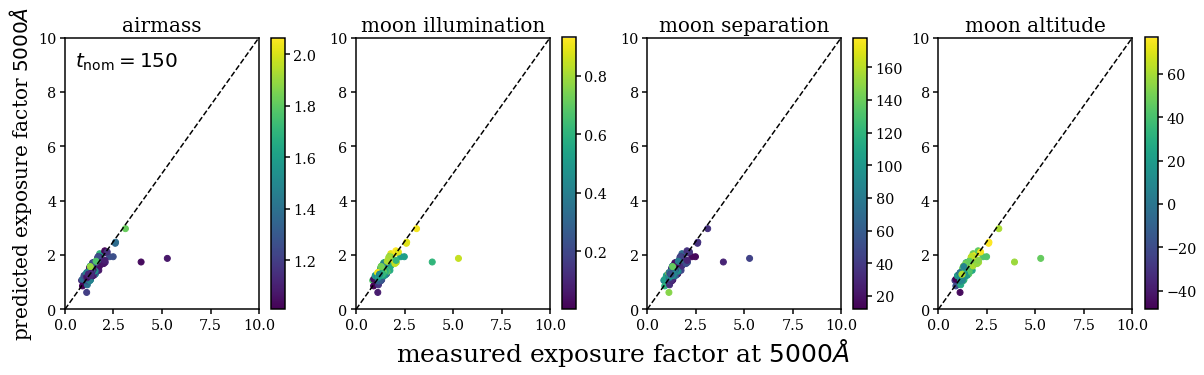

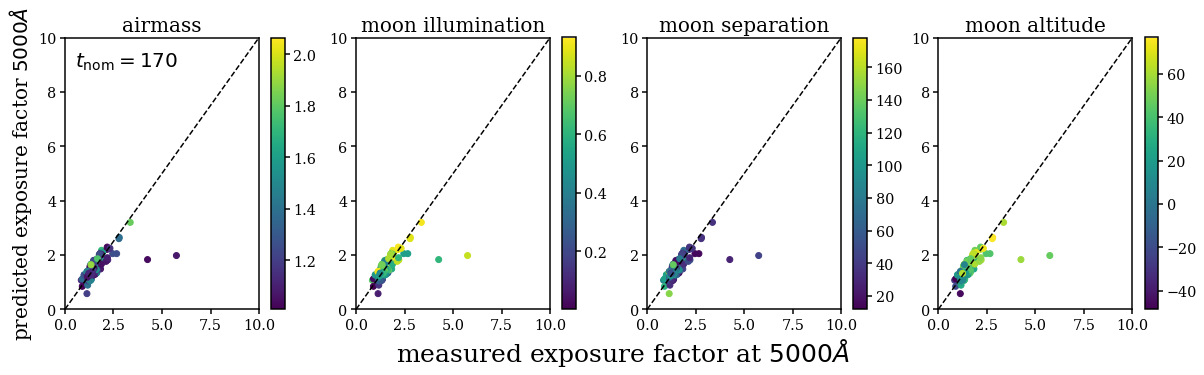

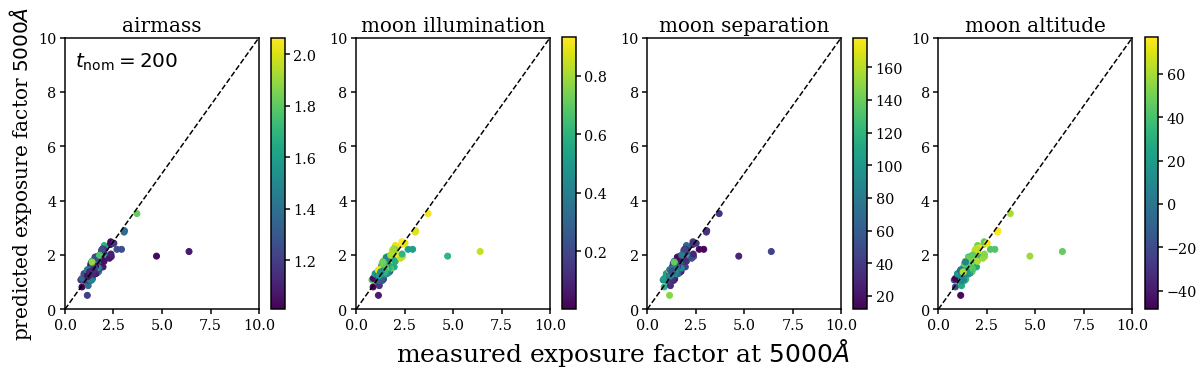

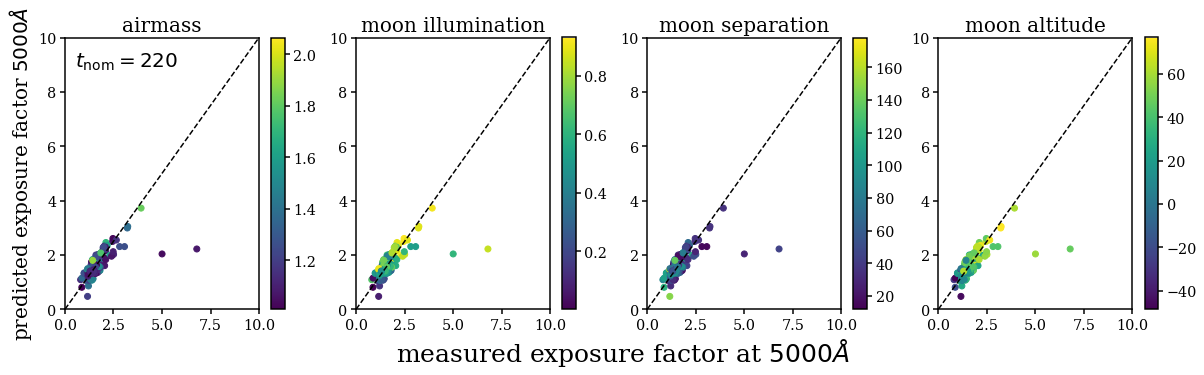

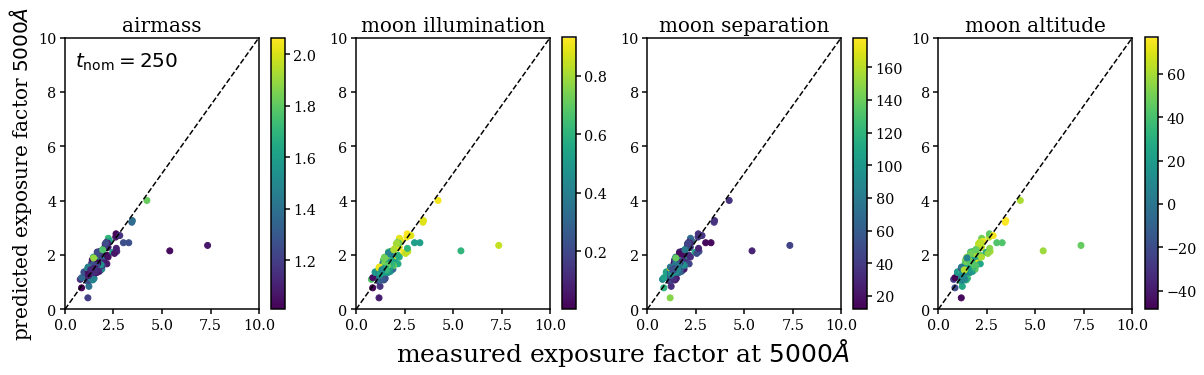

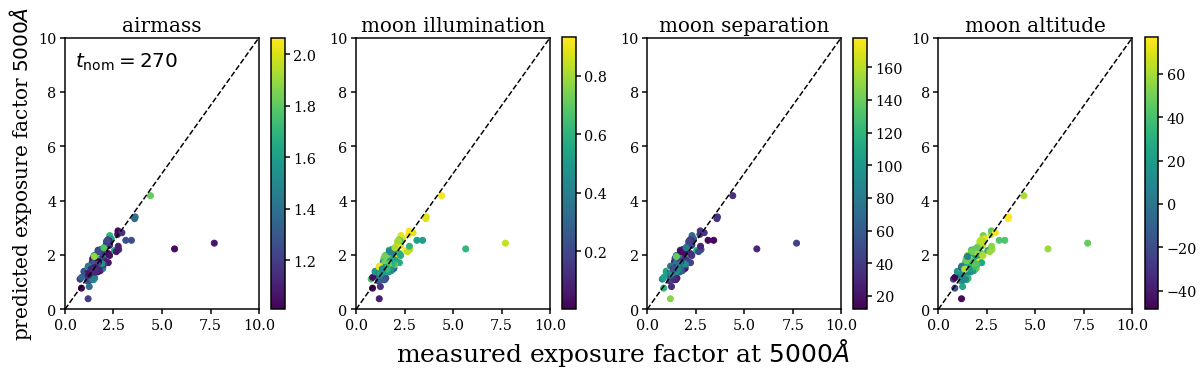

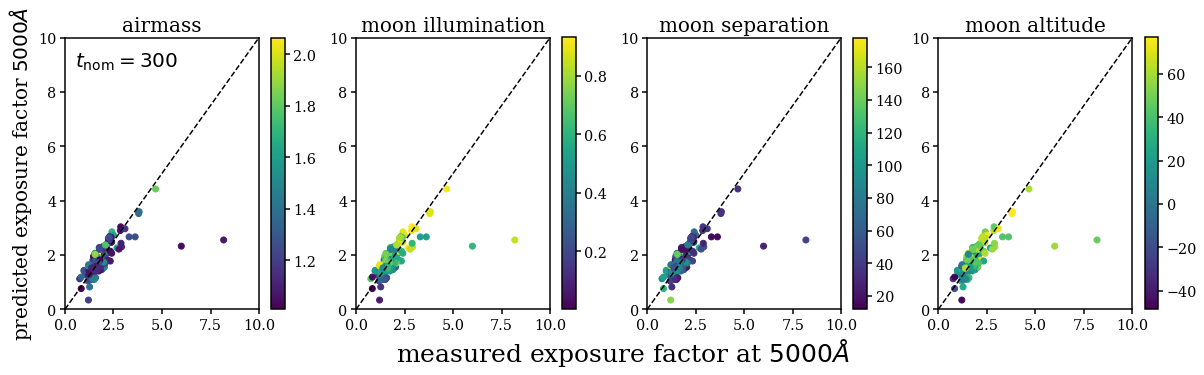

In [20]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude', 'sun separation', 'sun altitude']

desi_waves = [cmx_skies['wave_b'], cmx_skies['wave_r'], cmx_skies['wave_z']]
boss_waves = [boss_skies['wave_b'][i], boss_skies['wave_r'][i]]
sv1_waves = [sv1_wave]

for tnom in [150, 170, 200, 220, 250, 270, 300]: 
    _desi_fsky = np.zeros(len(cmx_skies['airmass']))
    for i in range(len(cmx_skies['airmass'])): 
        _desi_fsky[i] = get_exposure_factor(desi_waves, [cmx_skies['sky_b'][i], cmx_skies['sky_r'][i], cmx_skies['sky_z'][i]], tnom=tnom, wavelength=5000)
        
    _boss_fsky = np.zeros(len(boss_skies['airmass']))
    for i in range(len(boss_skies['airmass'])): 
        _boss_fsky[i] = get_exposure_factor(boss_waves, [boss_skies['sky_b'][i], boss_skies['sky_r'][i]], tnom=tnom, wavelength=5000)

    _sv1_fsky = np.zeros(len(sv1_Iskies)) 
    for i in range(len(sv1_Iskies)):
        _sv1_fsky[i] = get_exposure_factor(sv1_waves, [sv1_Iskies[i]], tnom=tnom, wavelength=5000)
        
    theta_train, theta_test, fsky_train, fsky_test = train_test_split(
        np.vstack([
            np.concatenate([cmx_skies['airmass'], boss_skies['airmass'], sv1_obs_cond['AIRMASS']]),
            np.concatenate([cmx_skies['moon_ill'], boss_skies['moon_ill'], sv1_obs_cond['MOON_ILLUMINATION']]),
            np.concatenate([cmx_skies['moon_sep'], boss_skies['moon_sep'], sv1_obs_cond['MOON_SEP_DEG']]),
            np.concatenate([cmx_skies['moon_alt'], boss_skies['moon_alt'], 90. - sv1_obs_cond['MOON_ZD_DEG']])]).T, 
        np.concatenate([_desi_fsky, _boss_fsky, _sv1_fsky]), test_size=0.2, random_state=0)
    
    n_order = 3
    regress_fsky = make_pipeline(PolynomialFeatures(n_order), Ridge(alpha=0.1))
    regress_fsky.fit(theta_train, fsky_train)
    
    steps = regress_fsky.get_params()
    _notwiCoefficients = steps['ridge'].coef_
    _notwiIntercept = steps['ridge'].intercept_
    
    print('--- tnom = %.f --' % tnom)
    print(_notwiCoefficients)
    print(_notwiIntercept)
    def exposure_factor_model_sv1(airmass, moon_frac, moon_sep, moon_alt):
        ''' third degree polynomial regression fit to exposure factor
        '''
        theta = np.atleast_2d(np.array([airmass, moon_frac, moon_sep, moon_alt]).T)

        combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, n_order+1))
        theta_transform = np.empty((theta.shape[0], len(_notwiCoefficients)))
        for i, comb in enumerate(combs):
            theta_transform[:, i] = theta[:, comb].prod(1)

        return np.dot(theta_transform, _notwiCoefficients.T) + _notwiIntercept
    
    fig = plt.figure(figsize=(20,5))
    for i, k in enumerate(['airmass', 'moon_ill', 'moon_sep', 'moon_alt']):
        sub = fig.add_subplot(1,4,i+1)
        _plt = sub.scatter(fsky_test, exposure_factor_model_sv1(*theta_test.T), c=theta_test[:,i])
        sub.plot([0., 20.], [0., 20.], c='k', ls='--')
        sub.set_xlim([0., 10.])
        if i == 0: 
            sub.set_ylabel('predicted exposure factor $5000\AA$', fontsize=20)
            sub.text(0.05, 0.95, r'$t_{\rm nom} = %.f$' % tnom, transform=sub.transAxes, ha='left', va='top', fontsize=20)
        sub.set_ylim([0., 10.])
        sub.set_title(lbls[i], fontsize=20)
        fig.colorbar(_plt)

    bkgd = fig.add_subplot(111, frameon=False)
    bkgd.set_xlabel('measured exposure factor at $5000\AA$', fontsize=25) 
    bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)